#**1. Data Preprocessing**#

### **1.1 Import Data**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive/data_preprocessed_python

s01.dat  s05.dat  s09.dat  s13.dat  s17.dat  s21.dat  s25.dat  s29.dat
s02.dat  s06.dat  s10.dat  s14.dat  s18.dat  s22.dat  s26.dat  s30.dat
s03.dat  s07.dat  s11.dat  s15.dat  s19.dat  s23.dat  s27.dat  s31.dat
s04.dat  s08.dat  s12.dat  s16.dat  s20.dat  s24.dat  s28.dat  s32.dat


###**1.2 Reading Data** 

In [ ]:
import os
import time
import pickle
import pandas as pd
import numpy as np

from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

from tqdm import tqdm

!pip install mne==0.22.0
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore

!pip install fooof
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

     |████████████████████████████████| 6.9 MB 15.5 MB/s 
     |████████████████████████████████| 112 kB 28.5 MB/s 


In [ ]:
with open('/content/gdrive/MyDrive/data_preprocessed_python/s01.dat', 'rb') as f:
 raw_data = pickle.load(f, encoding='latin1')
 print(raw_data)

{'labels': array([[7.71, 7.6 , 6.9 , 7.83],
       [8.1 , 7.31, 7.28, 8.47],
       [8.58, 7.54, 9.  , 7.08],
       [4.94, 6.01, 6.12, 8.06],
       [6.96, 3.92, 7.19, 6.05],
       [8.27, 3.92, 7.  , 8.03],
       [7.44, 3.73, 7.08, 7.04],
       [7.32, 2.55, 6.32, 5.87],
       [4.04, 3.29, 3.62, 5.99],
       [1.99, 4.86, 2.04, 7.09],
       [2.99, 2.36, 3.63, 6.24],
       [2.71, 2.77, 3.4 , 7.35],
       [1.95, 3.12, 2.87, 6.18],
       [4.18, 2.24, 3.04, 5.04],
       [3.17, 8.08, 2.91, 5.04],
       [6.81, 7.44, 8.15, 7.14],
       [2.46, 6.91, 6.77, 6.41],
       [7.23, 7.15, 6.94, 8.01],
       [7.17, 8.  , 8.1 , 6.79],
       [8.26, 7.91, 7.19, 8.13],
       [9.  , 7.95, 8.37, 7.86],
       [7.09, 2.08, 7.06, 7.37],
       [8.15, 3.01, 7.37, 7.9 ],
       [7.04, 7.09, 8.01, 8.22],
       [8.86, 7.21, 8.65, 7.21],
       [7.28, 7.27, 7.41, 8.24],
       [7.35, 6.95, 7.03, 7.29],
       [3.88, 3.35, 4.01, 7.87],
       [1.36, 2.27, 3.  , 8.14],
       [2.08, 2.99, 3.22, 7.33],

In [ ]:
data = raw_data['data']
labels = raw_data['labels']

print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data

Labels:  (40, 4)
Data:  (40, 40, 8064)


###**1.3 Reducing the Raw Data upto 40 32 7680**

In [ ]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [ ]:
eeg_data = []
for i in range (len(data)):
  for j in range (len(eeg_channels)):
    eeg_data.append(data[i,j])
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

(40, 32, 8064)


In [ ]:
reduced_eeg_data  = eeg_data[:, :32, 384:8064]
reduced_eeg_data.shape
print(type(reduced_eeg_data))

<class 'numpy.ndarray'>


In [ ]:
len(reduced_eeg_data)

40

In [ ]:
peripheral_data = []
for i in range (len(data)):
  for j in range (32,len(data[0])):
    peripheral_data.append(data[i,j])
peripheral_data = np.reshape(peripheral_data, (len(data), len(peripheral_channels), len(data[0,0])))
print(peripheral_data.shape)

(40, 8, 8064)


In [ ]:
len(peripheral_data)

40

###**1.4  Discretize the labels Rating 1-5: as low valence /low arousal Rating 6-9: high valence/high arousal**

In [ ]:
# Only extract Valence and Arousal ratings
df_label_ratings = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1]})
print(df_label_ratings.describe())

        Valence    Arousal
count  40.00000  40.000000
mean    5.11775   5.659750
std     2.51712   2.179549
min     1.36000   2.080000
25%     2.85250   3.335000
50%     4.56000   6.915000
75%     7.32750   7.342500
max     9.00000   8.150000


In [ ]:
print(df_label_ratings.head(15))

    Valence  Arousal
0      7.71     7.60
1      8.10     7.31
2      8.58     7.54
3      4.94     6.01
4      6.96     3.92
5      8.27     3.92
6      7.44     3.73
7      7.32     2.55
8      4.04     3.29
9      1.99     4.86
10     2.99     2.36
11     2.71     2.77
12     1.95     3.12
13     4.18     2.24
14     3.17     8.08


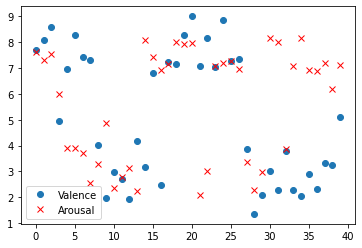

In [ ]:
# Plot the first 40 data rows (first participant)
df_label_ratings.iloc[0:40].plot(style=['o','rx'])

In [ ]:
# High Arousal Positive Valence dataset
df_hahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Positive Valence dataset
df_lahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]
# High Arousal Negative Valence dataset
df_halv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Negative Valence dataset
df_lalv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]

In [ ]:
# Check nummber of trials per each group
print("Positive Valence:", str(len(df_hahv) + len(df_lahv)))
print("Negative Valence:", str(len(df_halv) + len(df_lalv)))
print("High Arousal:", str(len(df_hahv) + len(df_halv)))
print("Low Arousal:", str(len(df_lahv) + len(df_lalv)))

Positive Valence: 20
Negative Valence: 20
High Arousal: 20
Low Arousal: 20


In [ ]:
# Check nummber of trials per each group
print("High Arousal Positive Valence:", str(len(df_hahv)))
print("Low Arousal Positive Valence:", str(len(df_lahv)))
print("High Arousal Negative Valence:", str(len(df_halv)))
print("Low Arousal Negative Valence:", str(len(df_lalv)))

High Arousal Positive Valence: 13
Low Arousal Positive Valence: 7
High Arousal Negative Valence: 7
Low Arousal Negative Valence: 13


In [ ]:
# Get mean and std of each group
print("HAHV")
print("Valence:", "Mean", np.round(df_hahv['Valence'].mean(),2), "STD", np.round(df_hahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_hahv['Arousal'].mean(),2), "STD", np.round(df_hahv['Arousal'].std(),2))
print()
print("LAHV:")
print("Valence:", "Mean", np.round(df_lahv['Valence'].mean(),2), "STD", np.round(df_lahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lahv['Arousal'].mean(),2), "STD", np.round(df_lahv['Arousal'].std(),2))
print()
print("HALV:")
print("Valence:", "Mean", np.round(df_halv['Valence'].mean(),2), "STD", np.round(df_halv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_halv['Arousal'].mean(),2), "STD", np.round(df_halv['Arousal'].std(),2))
print()
print("LALV:")
print("Valence:", "Mean", np.round(df_lalv['Valence'].mean(),2), "STD", np.round(df_lalv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lalv['Arousal'].mean(),2), "STD", np.round(df_lalv['Arousal'].std(),2))

HAHV
Valence: Mean 7.58 STD 1.04
Arousal: Mean 7.43 STD 0.35

LAHV:
Valence: Mean 7.17 STD 1.1
Arousal: Mean 3.6 STD 1.28

HALV:
Valence: Mean 2.72 STD 0.5
Arousal: Mean 7.65 STD 0.56

LALV:
Valence: Mean 2.85 STD 0.92
Arousal: Mean 3.93 STD 1.71


###**1.5 Filtering Data Through Butterworth Bandpass Filter**

In [ ]:
info = mne.create_info(ch_names=("Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"), sfreq=128, ch_types='eeg')
#info = mne.create_info(32, sfreq=128)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [ ]:
reduced_data_array = mne.io.RawArray(reduced_eeg_data[32], info)

Creating RawArray with float64 data, n_channels=32, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.


In [ ]:
print(reduced_data_array)

<RawArray | 32 x 7680 (60.0 s), ~1.9 MB, data loaded>


In [ ]:
# Checking info for channel names, frequency
info = reduced_data_array.info
print(reduced_data_array.info)

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [ ]:
bandpass_filt_data = reduced_data_array.filter(4,45, method='iir')
print(bandpass_filt_data)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 45 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 45.00 Hz: -6.02, -6.02 dB

<RawArray | 32 x 7680 (60.0 s), ~1.9 MB, data loaded>


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


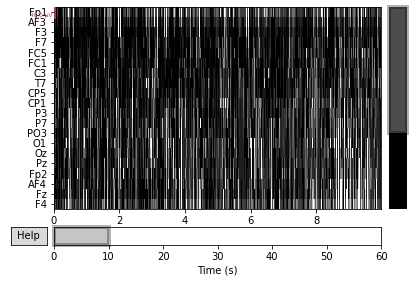

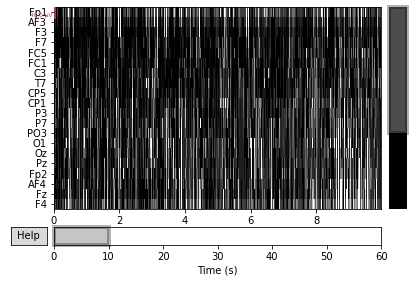

In [ ]:
bandpass_filt_data.plot()

###**1.6 Removal of artifacts using Independent Component Analysis(ICA)**

In [ ]:
info = mne.create_info(eeg_channels.tolist(), ch_types=32*['eeg'], sfreq=128)
info.set_montage('standard_1020')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [ ]:
info = mne.create_info(ch_names=("Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"), sfreq=128, ch_types='eeg')
#info = mne.create_info(32, sfreq=128)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [ ]:
# Checking Dictionary keys
print(info.keys())
print()  # insert a blank line
print(info['ch_names'])

dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2']


In [ ]:
# Checking keys for the channels
print(info['chs'])

[{'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'unit_mul': 0 (FIFF_UNITM_NONE), 'range': 1.0, 'cal': 1.0, 'kind': 2 (FIFFV_EEG_CH), 'coil_type': 1 (FIFFV_COIL_EEG), 'unit': 107 (FIFF_UNIT_V), 'coord_frame': 4 (FIFFV_COORD_HEAD), 'ch_name': 'Fp1', 'scanno': 1, 'logno': 1}, {'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'unit_mul': 0 (FIFF_UNITM_NONE), 'range': 1.0, 'cal': 1.0, 'kind': 2 (FIFFV_EEG_CH), 'coil_type': 1 (FIFFV_COIL_EEG), 'unit': 107 (FIFF_UNIT_V), 'coord_frame': 4 (FIFFV_COORD_HEAD), 'ch_name': 'AF3', 'scanno': 2, 'logno': 2}, {'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'unit_mul': 0 (FIFF_UNITM_NONE), 'range': 1.0, 'cal': 1.0, 'kind': 2 (FIFFV_EEG_CH), 'coil_type': 1 (FIFFV_COIL_EEG), 'unit': 107 (FIFF_UNIT_V), 'coord_frame': 4 (FIFFV_COORD_HEAD), 'ch_name': 'F3', 'scanno': 3, 'logno': 3}, {'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'unit_mul': 0 

In [ ]:
# Confirming EEG channels
eeg_ch = mne.pick_channels(info['ch_names'], include=['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 
                                                   'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 
                                                   'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz'])
print(eeg_ch)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


In [ ]:
ica = mne.preprocessing.ICA(n_components=32, random_state=0)
ica_filt_data = ica.fit(bandpass_filt_data)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 2.4s.


<ipython-input-28-eb6de62de4b0>:2: RuntimeWarning: Using n_components=32 (resulting in n_components_=32) may lead to an unstable mixing matrix estimation because the ratio between the largest (13) and smallest (2.9e-30) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 31
  ica_filt_data = ica.fit(bandpass_filt_data)


In [ ]:
print(ica_filt_data)

<ICA | raw data decomposition, fit (fastica): 7680 samples, 32 components, channels used: "eeg">


In [ ]:
# Plotting Scalp Field Distribution of each component
ica.plot_components()

RuntimeError: ignored

 **To set the reference to the default that came with the headset**

In [ ]:
bandpass_filt_data.set_eeg_reference([]) 

EEG channel type selected for re-referencing
EEG data marked as already having the desired reference.


<RawArray | 32 x 7680 (60.0 s), ~1.9 MB, data loaded>

**To set the reference to a custom combination of electrodes**

In [ ]:
bandpass_filt_data.set_eeg_reference(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])  

EEG channel type selected for re-referencing
Applying a custom EEG reference.


<RawArray | 32 x 7680 (60.0 s), ~1.9 MB, data loaded>

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


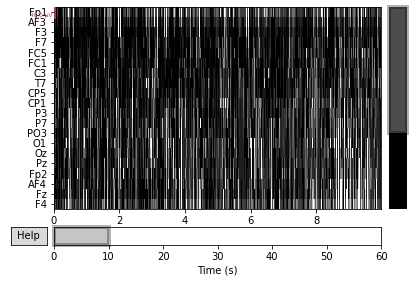

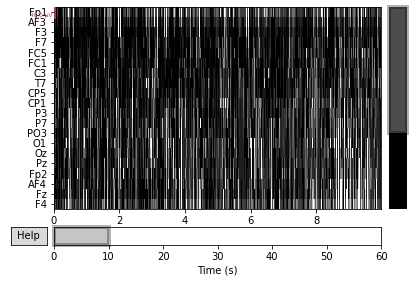

In [ ]:
raw_avg_ref = bandpass_filt_data.copy().set_eeg_reference(ref_channels='average')
raw_avg_ref.plot()

In [ ]:
print(raw_avg_ref)
print(type(raw_avg_ref))

<RawArray | 32 x 7680 (60.0 s), ~1.9 MB, data loaded>
<class 'mne.io.array.array.RawArray'>


In [ ]:
h = raw_avg_ref.to_data_frame

In [ ]:
h = raw_avg_ref[:][0]
print(h)
h.shape

[[ 1.50247927e-03  2.12821475e+00  2.09710970e+00 ...  1.49445370e-01
  -1.71696296e+00  6.59681128e-03]
 [ 3.61839991e-04 -3.77631276e-02 -2.95640145e+00 ... -9.15252367e-01
  -1.89617496e+00  1.05090385e-03]
 [ 5.84075023e-04  3.86017045e+00 -5.22437118e+00 ... -4.36935759e-02
  -1.40470531e+00  2.52967643e-03]
 ...
 [ 2.55045511e-03  6.28374332e-02  7.36982179e+00 ... -2.02510872e+00
  -9.40426202e-01  5.58680607e-04]
 [-6.88862844e-04 -1.48792031e-01  7.74401534e-01 ...  3.37074669e+00
   2.83736709e+00  2.38039205e-03]
 [-1.44022415e-03 -2.49059472e+00 -2.03555503e+00 ...  7.97494635e-01
  -3.12561267e-01  2.38824029e-03]]


(32, 7680)

In [ ]:
print(type(h))

<class 'numpy.ndarray'>


In [ ]:
import numpy as numpy
out_array = numpy.array_str(h)
print(out_array)
print(type(out_array))
len(out_array)

[[ 1.50247927e-03  2.12821475e+00  2.09710970e+00 ...  1.49445370e-01
  -1.71696296e+00  6.59681128e-03]
 [ 3.61839991e-04 -3.77631276e-02 -2.95640145e+00 ... -9.15252367e-01
  -1.89617496e+00  1.05090385e-03]
 [ 5.84075023e-04  3.86017045e+00 -5.22437118e+00 ... -4.36935759e-02
  -1.40470531e+00  2.52967643e-03]
 ...
 [ 2.55045511e-03  6.28374332e-02  7.36982179e+00 ... -2.02510872e+00
  -9.40426202e-01  5.58680607e-04]
 [-6.88862844e-04 -1.48792031e-01  7.74401534e-01 ...  3.37074669e+00
   2.83736709e+00  2.38039205e-03]
 [-1.44022415e-03 -2.49059472e+00 -2.03555503e+00 ...  7.97494635e-01
  -3.12561267e-01  2.38824029e-03]]
<class 'str'>


635

In [ ]:
car_data = []
for i in range (len(out_array)):
  for j in range (len(eeg_channels)):
    car_data.append(out_array[i,j])
car_data = np.reshape(car_data, (len(out_array), len(eeg_channels), len(out_array[0,0])))
print(car_data.shape)

TypeError: ignored

#**2. Feature Extraction**



In [ ]:
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 128.
time = np.arange(out_array.size) / sf

# Plot the signal of first trial, last channel 
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(out_array[0,7679], lw=1.5, color='k') 
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()

AttributeError: ignored

In [ ]:
# Define window length (4 seconds)
win = 4 * sf
freqs, psd = signal.welch(h[0,31], sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

IndexError: ignored

###**2.1 Theta Band Power(4-8)Hz**

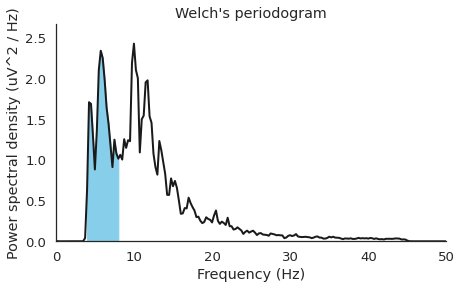

In [ ]:
# Define delta lower and upper limits
low, high = 4, 8

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

###**2.3 Alpha Band Power(8-12)Hz**

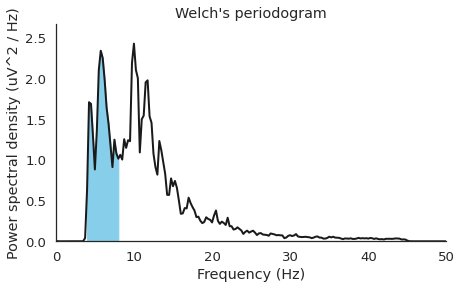

In [ ]:
# Define delta lower and upper limits
low, high = 8, 12

# Find intersecting values in frequency vector
idx_d = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the alpha area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

###**2.4 Beta Band Power(12-30)Hz**

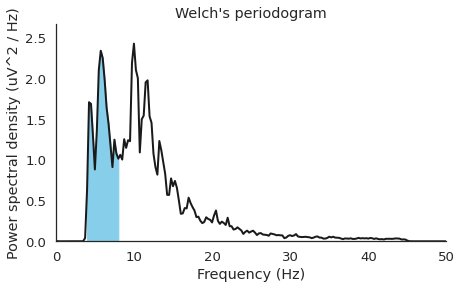

In [ ]:
# Define beta lower and upper limits
low, high = 12, 30

# Find intersecting values in frequency vector
idx_beta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the beta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

###**2.5 Gamma Band Power(30-45)Hz**

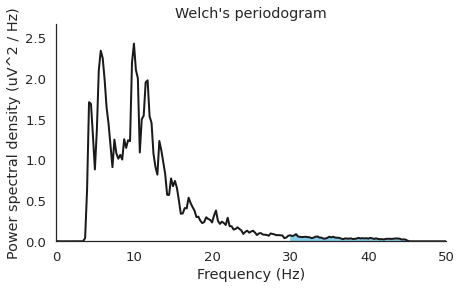

In [ ]:
# Define gamma lower and upper limits
low, high = 30, 45

# Find intersecting values in frequency vector
idx_gamma = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the gamma area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_gamma, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()